# Customer Lifetime Value: Modeling Customer Profile for Underwriting Optimization
### The goal of this project is to create a model that predicts the customer lifetime values (CLV) of a given customer profile for auto insurance underwriting. 

## Load the data set and import libraries

In [2]:
## import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

#set plotting style
sns.set_style('whitegrid')

In [42]:
clv_df = pd.read_csv(
    'https://raw.githubusercontent.com/brisamh/modeling_clv/refs/heads/bhalviatti/data/clean_clv_data.csv')

In [43]:
pd.set_option('display.max_columns', None)
clv_df.head()

,customer,state,customer_lifetime_value,customer_response_to_offer,coverage,education,policy_expiration_date,employment_status,gender,income,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


## Modeling Entire Data

#### Before fitting the model we will drop data we do not need and perform one-hot encoding of categorical variables

In [44]:
clv_df_model_all = clv_df.drop(columns = ['customer', 'policy_expiration_date'])

We will convert the categorical variables to dummies dropping the first variable in each category.

In [45]:
clv_df_model_all = pd.get_dummies(clv_df_model_all, drop_first=True)

Find all columns in  clv_df that have the Boolean data type and convert them to 0 and 1.

In [47]:
bool_cols = clv_df_model_all.select_dtypes(include='bool').columns
clv_df_model_all[bool_cols] = clv_df_model_all[bool_cols].astype(int)

Create OLS Model

In [48]:
X = clv_df_model_all.drop(columns = 'customer_lifetime_value') 
y = clv_df_model_all['customer_lifetime_value'] 

In [49]:
X = sm.add_constant(X)
model_all = sm.OLS(y, X).fit()
print(model_all.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.169
Model:                                 OLS   Adj. R-squared:                  0.165
Method:                      Least Squares   F-statistic:                     38.60
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):          6.92e-323
Time:                             18:13:40   Log-Likelihood:                -92812.
No. Observations:                     9134   AIC:                         1.857e+05
Df Residuals:                         9085   BIC:                         1.861e+05
Df Model:                               48                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [50]:
print(model_all.pvalues[model_all.pvalues < 0.05].drop('const', errors='ignore'))

monthly_premium_auto              4.187587e-12
number_of_open_complaints         2.686336e-04
number_of_policies                3.759583e-02
education_High School or Below    2.491937e-02
employment_status_Employed        4.818648e-02
marital_status_Single             2.972820e-02
policy_Corporate L2               1.662197e-02
renew_offer_type_Offer2           5.389205e-09
renew_offer_type_Offer3           7.542192e-03
renew_offer_type_Offer4           2.989086e-07
dtype: float64


### Full Model Interpretation:
* We have included all the variables in our model to begin with, but the R-Squared is only 0.169
* Of 49 variables, only 10 were statistically significant (p-value < 0.05)
* We did not include any interaction terms, despite seeing a 'stripe' effect in our data that indicates variable interactions
* If our model continues to lack explanatory power, we may have to opt for a different model like Random Forest or Neural Network.

## Modeling Data with the 75th percentile CLV

In [51]:
clv_df[clv_df['number_of_policies'] == 2].describe()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
count,2294.000000,2294.000000,2294.000000,2294.000000,2294.000000,2294.000000,2294.0,2294.000000
mean,15723.177937,37001.553182,93.261552,15.044900,47.812554,0.364429,2.0,433.610653
std,9300.866249,30051.712074,33.426835,9.996519,27.948144,0.858842,0.0,282.363856
min,5409.955926,0.000000,61.000000,0.000000,0.000000,0.000000,2.0,1.489470
25%,8642.421929,0.000000,68.250000,6.000000,23.000000,0.000000,2.0,276.103498
50%,12876.687620,33551.000000,85.000000,14.000000,48.000000,0.000000,2.0,393.600000
75%,19916.955327,61108.000000,109.000000,23.000000,71.000000,0.000000,2.0,547.031224
max,83325.381190,99875.000000,295.000000,35.000000,99.000000,5.000000,2.0,2552.343856


In [52]:
seventyfifth_percentile = clv_df_model_all[clv_df_model_all['customer_lifetime_value'] < 19916.955327]

In [53]:
X = seventyfifth_percentile.drop(columns = 'customer_lifetime_value')
y = seventyfifth_percentile['customer_lifetime_value'] 

In [54]:
seventyfifth_percentile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8555 entries, 0 to 9133
Data columns (total 51 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   customer_lifetime_value          8555 non-null   float64
 1   income                           8555 non-null   int64  
 2   monthly_premium_auto             8555 non-null   int64  
 3   months_since_last_claim          8555 non-null   int64  
 4   months_since_policy_inception    8555 non-null   int64  
 5   number_of_open_complaints        8555 non-null   int64  
 6   number_of_policies               8555 non-null   int64  
 7   total_claim_amount               8555 non-null   float64
 8   state_California                 8555 non-null   int64  
 9   state_Nevada                     8555 non-null   int64  
 10  state_Oregon                     8555 non-null   int64  
 11  state_Washington                 8555 non-null   int64  
 12  customer_response_to_offe

In [55]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.247
Model:                                 OLS   Adj. R-squared:                  0.243
Method:                      Least Squares   F-statistic:                     58.09
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             18:14:01   Log-Likelihood:                -81290.
No. Observations:                     8555   AIC:                         1.627e+05
Df Residuals:                         8506   BIC:                         1.630e+05
Df Model:                               48                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

## Explain as to why the above model is not fit for our data

In [56]:
print(model.pvalues[model.pvalues < 0.05].drop('const', errors='ignore'))

monthly_premium_auto         2.358791e-14
number_of_open_complaints    7.639587e-05
number_of_policies           3.645461e-84
coverage_Premium             4.259707e-02
education_College            4.922172e-02
education_Master             2.954872e-02
marital_status_Single        9.462825e-03
policy_Corporate L2          2.816731e-02
policy_Corporate L3          2.086841e-02
policy_Personal L3           4.276820e-02
renew_offer_type_Offer2      3.923400e-13
renew_offer_type_Offer3      3.827024e-04
renew_offer_type_Offer4      7.756365e-11
vehicle_class_SUV            5.807066e-03
vehicle_size_Small           3.317256e-02
dtype: float64


## Modeling Data with Interaction Terms

From the EDA, we know that vast amount of variation, skew, and spread comes from having two policies. We will create a dummy variable to account for this:

In [57]:
clv_df['two_policies'] = (clv_df['number_of_policies'] == 2).astype(int)

In [58]:
clv_df.head(5)

,customer,state,customer_lifetime_value,customer_response_to_offer,coverage,education,policy_expiration_date,employment_status,gender,income,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,two_policies
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,0
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,0
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize,1
3,WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize,0
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize,0


Re-run the full model results, but include the interaction between policy premium and a Y/N flag for two policies:

In [59]:
X['two_policies'] = (X['number_of_policies'] == 2).astype(int)
X['premium_policy_intrxn'] = X['two_policies'] * X['monthly_premium_auto']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.788
Model:                                 OLS   Adj. R-squared:                  0.787
Method:                      Least Squares   F-statistic:                     631.9
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             18:14:34   Log-Likelihood:                -75869.
No. Observations:                     8555   AIC:                         1.518e+05
Df Residuals:                         8504   BIC:                         1.522e+05
Df Model:                               50                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [60]:
print(model.pvalues[model.pvalues < 0.05].drop('const', errors='ignore'))

income                             6.385091e-03
monthly_premium_auto               9.605256e-66
number_of_open_complaints          6.782787e-09
number_of_policies                 0.000000e+00
total_claim_amount                 2.279444e-03
state_California                   3.517096e-02
customer_response_to_offer_Yes     1.224983e-04
education_College                  2.305924e-02
education_High School or Below     7.937718e-03
education_Master                   8.340362e-06
employment_status_Employed         6.547546e-03
gender_M                           2.333341e-05
location_code_Suburban             1.159276e-02
location_code_Urban                1.173485e-02
marital_status_Single              7.698499e-03
renew_offer_type_Offer4            1.951973e-03
vehicle_class_SUV                  3.088724e-03
vehicle_class_Sports Car           9.636216e-03
vehicle_size_Small                 2.106186e-02
two_policies                      4.176693e-169
premium_policy_intrxn              5.897

Can we achieve similiar results with a reduced model, including the interaction?

In [19]:
model_interactions = smf.ols(formula='customer_lifetime_value ~ (monthly_premium_auto) * (two_policies)'
                             , data=clv_df).fit()

In [20]:
print(model_interactions.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.627
Model:                                 OLS   Adj. R-squared:                  0.627
Method:                      Least Squares   F-statistic:                     5108.
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             17:33:15   Log-Likelihood:                -89160.
No. Observations:                     9134   AIC:                         1.783e+05
Df Residuals:                         9130   BIC:                         1.784e+05
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

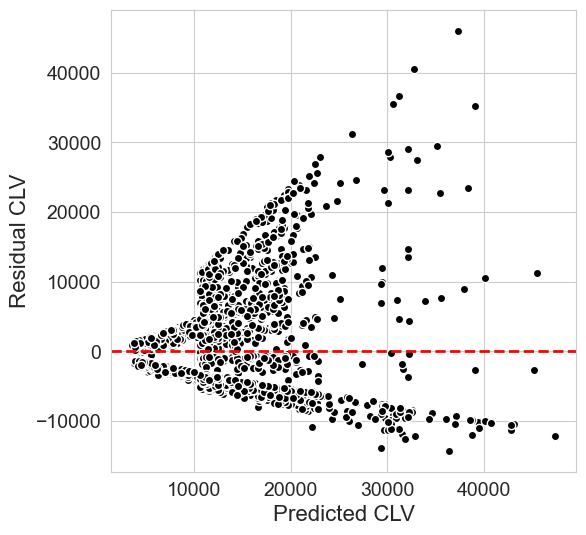

In [21]:
y_hat = model_interactions.predict()

plt.figure(figsize=(6,6))

plt.plot(y_hat, model_interactions.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted CLV', fontsize=16)
plt.ylabel('Residual CLV', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

Add some categorical data back in:

In [ ]:
model_interactions = smf.ols(
    formula='customer_lifetime_value ~ (monthly_premium_auto + number_of_open_complaints + C(coverage)  + C(location_code)) * two_policies',
    data=clv_df
).fit()
 

In [23]:
print(model_interactions.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.630
Model:                                 OLS   Adj. R-squared:                  0.630
Method:                      Least Squares   F-statistic:                     1195.
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             17:33:15   Log-Likelihood:                -89117.
No. Observations:                     9134   AIC:                         1.783e+05
Df Residuals:                         9120   BIC:                         1.784e+05
Df Model:                               13                                         
Covariance Type:                 nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

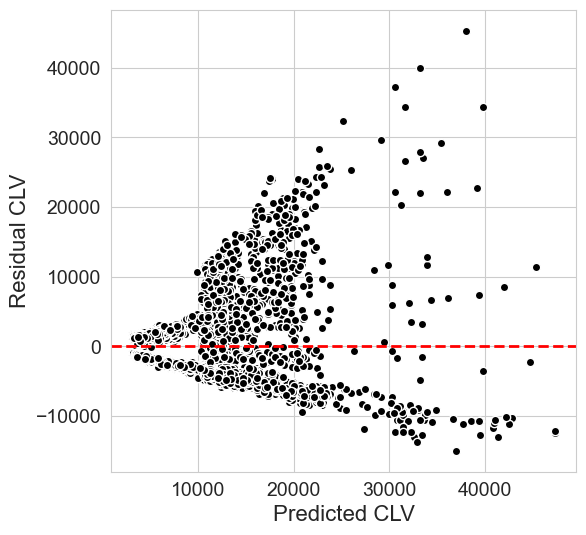

In [24]:
y_hat = model_interactions.predict()

plt.figure(figsize=(6,6))

plt.plot(y_hat, model_interactions.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted CLV', fontsize=16)
plt.ylabel('Residual CLV', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

## Explain why this model is not fit for our data

## Individual policy count model

In [64]:
clv_df_1pol = clv_df_model_all.loc[clv_df_model_all['number_of_policies'] == 1] 
clv_df_2pol = clv_df_model_all.loc[clv_df_model_all['number_of_policies'] == 2] 
clv_df_3pol = clv_df_model_all.loc[clv_df_model_all['number_of_policies'] == 3] 
clv_df_4pol = clv_df_model_all.loc[clv_df_model_all['number_of_policies'] == 4] 
clv_df_5pol = clv_df_model_all.loc[clv_df_model_all['number_of_policies'] == 5] 
clv_df_6pol = clv_df_model_all.loc[clv_df_model_all['number_of_policies'] == 6] 
clv_df_7pol = clv_df_model_all.loc[clv_df_model_all['number_of_policies'] == 7] 
clv_df_8pol = clv_df_model_all.loc[clv_df_model_all['number_of_policies'] == 8] 
clv_df_9pol = clv_df_model_all.loc[clv_df_model_all['number_of_policies'] == 9]
 

In [81]:
clv_df_2pol

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,state_California,state_Nevada,state_Oregon,state_Washington,customer_response_to_offer_Yes,coverage_Extended,coverage_Premium,education_College,education_Doctor,education_High School or Below,education_Master,employment_status_Employed,employment_status_Medical Leave,employment_status_Retired,employment_status_Unemployed,gender_M,location_code_Suburban,location_code_Urban,marital_status_Married,marital_status_Single,policy_type_Personal Auto,policy_type_Special Auto,policy_Corporate L2,policy_Corporate L3,policy_Personal L1,policy_Personal L2,policy_Personal L3,policy_Special L1,policy_Special L2,policy_Special L3,renew_offer_type_Offer2,renew_offer_type_Offer3,renew_offer_type_Offer4,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
2,12887.431650,48767,108,18,38,0,2,566.472247,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
5,8256.297800,62902,69,14,94,0,2,159.383042,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0
8,24127.504020,14072,71,13,3,0,2,511.200000,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
15,7463.139377,24599,64,12,50,1,2,42.920271,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
22,24127.504020,14072,71,13,3,0,2,511.200000,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9122,25464.820590,13663,97,1,66,0,2,465.600000,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
9124,16261.585500,60646,134,31,42,0,2,643.200000,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
9125,19872.262000,0,185,26,35,0,2,1950.725547,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
9129,23405.987980,71941,73,18,89,0,2,198.234764,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0


In [79]:
clv_df_1pol= pd.get_dummies(clv_df_1pol, drop_first=True)
bool_cols = clv_df_1pol.select_dtypes(include='bool').columns
clv_df_1pol[bool_cols] = clv_df_1pol[bool_cols].astype(int)
X = clv_df_1pol.drop(columns = 'customer_lifetime_value') # X is the predictor variable
y = clv_df_1pol['customer_lifetime_value'] # y is the response variable
# One-hot encode categorical variable
# Add constant term (intercept)
X = sm.add_constant(X)
# Fit OLS model
model1 = sm.OLS(y, X).fit()
# Print detailed summary
print(model1.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.996
Model:                                 OLS   Adj. R-squared:                  0.996
Method:                      Least Squares   F-statistic:                 1.595e+04
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             20:59:03   Log-Likelihood:                -19317.
No. Observations:                     3251   AIC:                         3.873e+04
Df Residuals:                         3203   BIC:                         3.902e+04
Df Model:                               47                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [83]:
clv_df_2pol= pd.get_dummies(clv_df_2pol, drop_first=True)
bool_cols = clv_df_2pol.select_dtypes(include='bool').columns
clv_df_2pol[bool_cols] = clv_df_2pol[bool_cols].astype(int)
X = clv_df_2pol.drop(columns = 'customer_lifetime_value') # X is the predictor variable
y = clv_df_2pol['customer_lifetime_value'] # y is the response variable
# One-hot encode categorical variable
# Add constant term (intercept)
X = sm.add_constant(X)
# Fit OLS model
model2 = sm.OLS(y, X).fit()
# Print detailed summary
print(model2.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.340
Model:                                 OLS   Adj. R-squared:                  0.326
Method:                      Least Squares   F-statistic:                     24.58
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):          1.14e-166
Time:                             20:59:49   Log-Likelihood:                -23741.
No. Observations:                     2294   AIC:                         4.758e+04
Df Residuals:                         2246   BIC:                         4.785e+04
Df Model:                               47                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [82]:
clv_df_3pol= pd.get_dummies(clv_df_3pol, drop_first=True)
bool_cols = clv_df_3pol.select_dtypes(include='bool').columns
clv_df_3pol[bool_cols] = clv_df_3pol[bool_cols].astype(int)
X = clv_df_3pol.drop(columns = 'customer_lifetime_value') # X is the predictor variable
y = clv_df_3pol['customer_lifetime_value'] # y is the response variable
# One-hot encode categorical variable
# Add constant term (intercept)
X = sm.add_constant(X)
# Fit OLS model
model3 = sm.OLS(y, X).fit()
# Print detailed summary
print(model3.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.995
Model:                                 OLS   Adj. R-squared:                  0.995
Method:                      Least Squares   F-statistic:                     4620.
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             20:59:44   Log-Likelihood:                -7645.8
No. Observations:                     1168   AIC:                         1.539e+04
Df Residuals:                         1120   BIC:                         1.563e+04
Df Model:                               47                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [69]:
clv_df_4pol= pd.get_dummies(clv_df_4pol, drop_first=True)
bool_cols = clv_df_4pol.select_dtypes(include='bool').columns
clv_df_4pol[bool_cols] = clv_df_4pol[bool_cols].astype(int)
X = clv_df_4pol.drop(columns = 'customer_lifetime_value') # X is the predictor variable
y = clv_df_4pol['customer_lifetime_value'] # y is the response variable
# One-hot encode categorical variable
# Add constant term (intercept)
X = sm.add_constant(X)
# Fit OLS model
model4 = sm.OLS(y, X).fit()
# Print detailed summary
print(model4.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.995
Model:                                 OLS   Adj. R-squared:                  0.995
Method:                      Least Squares   F-statistic:                     1585.
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             18:26:33   Log-Likelihood:                -2676.2
No. Observations:                      409   AIC:                             5448.
Df Residuals:                          361   BIC:                             5641.
Df Model:                               47                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [70]:
clv_df_5pol= pd.get_dummies(clv_df_5pol, drop_first=True)
bool_cols = clv_df_5pol.select_dtypes(include='bool').columns
clv_df_5pol[bool_cols] = clv_df_5pol[bool_cols].astype(int)
X = clv_df_5pol.drop(columns = 'customer_lifetime_value') # X is the predictor variable
y = clv_df_5pol['customer_lifetime_value'] # y is the response variable
# One-hot encode categorical variable
# Add constant term (intercept)
X = sm.add_constant(X)
# Fit OLS model
model5 = sm.OLS(y, X).fit()
# Print detailed summary
print(model5.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.995
Model:                                 OLS   Adj. R-squared:                  0.995
Method:                      Least Squares   F-statistic:                     1612.
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             18:26:36   Log-Likelihood:                -2714.8
No. Observations:                      407   AIC:                             5526.
Df Residuals:                          359   BIC:                             5718.
Df Model:                               47                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [71]:
clv_df_6pol= pd.get_dummies(clv_df_6pol, drop_first=True)
bool_cols = clv_df_6pol.select_dtypes(include='bool').columns
clv_df_6pol[bool_cols] = clv_df_6pol[bool_cols].astype(int)
X = clv_df_6pol.drop(columns = 'customer_lifetime_value') # X is the predictor variable
y = clv_df_6pol['customer_lifetime_value'] # y is the response variable
# One-hot encode categorical variable
# Add constant term (intercept)
X = sm.add_constant(X)
# Fit OLS model
model6 = sm.OLS(y, X).fit()
# Print detailed summary
print(model6.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.995
Model:                                 OLS   Adj. R-squared:                  0.995
Method:                      Least Squares   F-statistic:                     1480.
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             18:26:39   Log-Likelihood:                -2422.7
No. Observations:                      372   AIC:                             4941.
Df Residuals:                          324   BIC:                             5129.
Df Model:                               47                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [72]:
clv_df_7pol= pd.get_dummies(clv_df_7pol, drop_first=True)
bool_cols = clv_df_7pol.select_dtypes(include='bool').columns
clv_df_7pol[bool_cols] = clv_df_7pol[bool_cols].astype(int)
X = clv_df_7pol.drop(columns = 'customer_lifetime_value') # X is the predictor variable
y = clv_df_7pol['customer_lifetime_value'] # y is the response variable
# One-hot encode categorical variable
# Add constant term (intercept)
X = sm.add_constant(X)
# Fit OLS model
model7 = sm.OLS(y, X).fit()
# Print detailed summary
print(model7.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.993
Model:                                 OLS   Adj. R-squared:                  0.992
Method:                      Least Squares   F-statistic:                     1209.
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             18:26:42   Log-Likelihood:                -3001.4
No. Observations:                      433   AIC:                             6099.
Df Residuals:                          385   BIC:                             6294.
Df Model:                               47                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [73]:
clv_df_8pol= pd.get_dummies(clv_df_8pol, drop_first=True)
bool_cols = clv_df_8pol.select_dtypes(include='bool').columns
clv_df_8pol[bool_cols] = clv_df_8pol[bool_cols].astype(int)
X = clv_df_8pol.drop(columns = 'customer_lifetime_value') # X is the predictor variable
y = clv_df_8pol['customer_lifetime_value'] # y is the response variable
# One-hot encode categorical variable
# Add constant term (intercept)
X = sm.add_constant(X)
# Fit OLS model
model8 = sm.OLS(y, X).fit()
# Print detailed summary
print(model8.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.995
Model:                                 OLS   Adj. R-squared:                  0.995
Method:                      Least Squares   F-statistic:                     1542.
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             18:26:44   Log-Likelihood:                -2527.0
No. Observations:                      384   AIC:                             5150.
Df Residuals:                          336   BIC:                             5340.
Df Model:                               47                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [74]:
clv_df_9pol= pd.get_dummies(clv_df_9pol, drop_first=True)
bool_cols = clv_df_9pol.select_dtypes(include='bool').columns
clv_df_9pol[bool_cols] = clv_df_9pol[bool_cols].astype(int)
X = clv_df_9pol.drop(columns = 'customer_lifetime_value') # X is the predictor variable
y = clv_df_9pol['customer_lifetime_value'] # y is the response variable
# One-hot encode categorical variable
# Add constant term (intercept)
X = sm.add_constant(X)
# Fit OLS model
model9 = sm.OLS(y, X).fit()
# Print detailed summary
print(model9.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.997
Model:                                 OLS   Adj. R-squared:                  0.996
Method:                      Least Squares   F-statistic:                     2347.
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             18:26:47   Log-Likelihood:                -2681.3
No. Observations:                      416   AIC:                             5459.
Df Residuals:                          368   BIC:                             5652.
Df Model:                               47                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [75]:
clv_df_exclude_2 = clv_df_model_all.loc[clv_df_model_all['number_of_policies'] != 2]

In [76]:
clv_df_exclude_2= pd.get_dummies(clv_df_exclude_2, drop_first=True)
bool_cols = clv_df_exclude_2.select_dtypes(include='bool').columns
clv_df_exclude_2[bool_cols] = clv_df_exclude_2[bool_cols].astype(int)
X = clv_df_exclude_2.drop(columns = 'customer_lifetime_value') # X is the predictor variable
y = clv_df_exclude_2['customer_lifetime_value'] # y is the response variable
# One-hot encode categorical variable
# Add constant term (intercept)
X = sm.add_constant(X)
# Fit OLS model
model10 = sm.OLS(y, X).fit()
# Print detailed summary
print(model10.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.796
Model:                                 OLS   Adj. R-squared:                  0.795
Method:                      Least Squares   F-statistic:                     553.4
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             18:29:17   Log-Likelihood:                -58336.
No. Observations:                     6840   AIC:                         1.168e+05
Df Residuals:                         6791   BIC:                         1.171e+05
Df Model:                               48                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [77]:
print(model10.pvalues[model10.pvalues < 0.05].drop('const', errors='ignore'))

income                             7.596567e-05
monthly_premium_auto              1.131773e-124
number_of_open_complaints          8.619995e-11
number_of_policies                 0.000000e+00
total_claim_amount                 3.135733e-05
customer_response_to_offer_Yes     1.144540e-07
education_High School or Below     5.855444e-03
education_Master                   7.618465e-05
employment_status_Retired          1.342744e-02
employment_status_Unemployed       1.540462e-02
gender_M                           4.690677e-02
location_code_Suburban             1.040491e-02
location_code_Urban                4.644049e-03
marital_status_Single              8.130403e-03
renew_offer_type_Offer2            8.304853e-06
renew_offer_type_Offer4            1.726583e-05
vehicle_class_SUV                  3.874128e-02
vehicle_size_Small                 4.151479e-02
dtype: float64


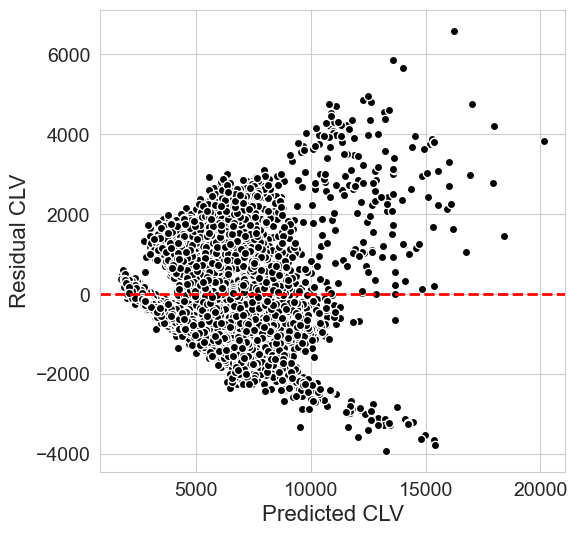

In [84]:
y_hat = model10.predict()

plt.figure(figsize=(6,6))

plt.plot(y_hat, model10.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted CLV', fontsize=16)
plt.ylabel('Residual CLV', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

In [86]:
clv_df_exclude_2 = clv_df.loc[clv_df['number_of_policies'] != 2]

In [116]:
model11 = smf.ols(
    formula='customer_lifetime_value ~ monthly_premium_auto + number_of_policies + income  ',
    data=clv_df_exclude_2
).fit()
print(model11.summary())

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.788
Model:                                 OLS   Adj. R-squared:                  0.788
Method:                      Least Squares   F-statistic:                     8473.
Date:                     Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                             23:53:55   Log-Likelihood:                -58474.
No. Observations:                     6840   AIC:                         1.170e+05
Df Residuals:                         6836   BIC:                         1.170e+05
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

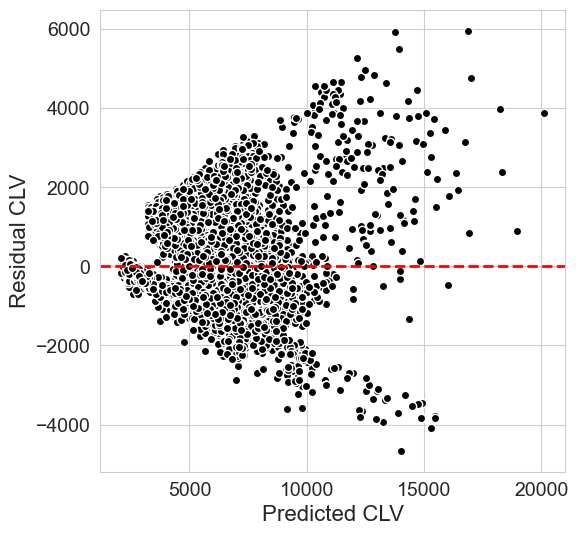

In [117]:
y_hat = model11.predict()

plt.figure(figsize=(6,6))

plt.plot(y_hat, model11.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted CLV', fontsize=16)
plt.ylabel('Residual CLV', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()